In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from sklearn.kernel_ridge import KernelRidge  # not a Nadaraya-Watson regression (!)

In [3]:
# source: https://github.com/jmetzen/kernel_regression


from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin


class KernelRegression(BaseEstimator, RegressorMixin):
    """Nadaraya-Watson kernel regression with automatic bandwidth selection.

    This implements Nadaraya-Watson kernel regression with (optional) automatic
    bandwith selection of the kernel via leave-one-out cross-validation. Kernel
    regression is a simple non-parametric kernelized technique for learning
    a non-linear relationship between input variable(s) and a target variable.

    Parameters
    ----------
    kernel : string or callable, default="rbf"
        Kernel map to be approximated. A callable should accept two arguments
        and the keyword arguments passed to this object as kernel_params, and
        should return a floating point number.

    gamma : float, default=None
        Gamma parameter for the RBF ("bandwidth"), polynomial,
        exponential chi2 and sigmoid kernels. Interpretation of the default
        value is left to the kernel; see the documentation for
        sklearn.metrics.pairwise. Ignored by other kernels. If a sequence of
        values is given, one of these values is selected which minimizes
        the mean-squared-error of leave-one-out cross-validation.

    See also
    --------

    sklearn.metrics.pairwise.kernel_metrics : List of built-in kernels.
    """

    def __init__(self, kernel="rbf", gamma=None):
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y):
        """Fit the model

        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The training input samples.

        y : array-like, shape = [n_samples]
            The target values

        Returns
        -------
        self : object
            Returns self.
        """
        self.X = X
        self.y = y

        if hasattr(self.gamma, "__iter__"):
            self.gamma = self._optimize_gamma(self.gamma)

        return self

    def predict(self, X):
        """Predict target values for X.

        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The input samples.

        Returns
        -------
        y : array of shape = [n_samples]
            The predicted target value.
        """
        K = pairwise_kernels(self.X, X, metric=self.kernel, gamma=self.gamma)
        return (K * self.y[:, None]).sum(axis=0) / K.sum(axis=0)

    def _optimize_gamma(self, gamma_values):
        # Select specific value of gamma from the range of given gamma_values
        # by minimizing mean-squared error in leave-one-out cross validation
        mse = np.empty_like(gamma_values, dtype=np.float)
        for i, gamma in enumerate(gamma_values):
            K = pairwise_kernels(self.X, self.X, metric=self.kernel,
                                 gamma=gamma)
            np.fill_diagonal(K, 0)  # leave-one-out
            Ky = K * self.y[:, np.newaxis]
            y_pred = Ky.sum(axis=0) / K.sum(axis=0)
            mse[i] = ((y_pred - self.y) ** 2).mean()

        return gamma_values[np.nanargmin(mse)]


In [4]:
X = np.concatenate([
    np.linspace(-1, -0.5, 25),
    np.array([-0.25, 0.0, 0.25]),
    np.linspace(0.5, 1, 25),
])[:, np.newaxis]
target_fn = lambda x: x[:, 0] ** 2
y = target_fn(X)

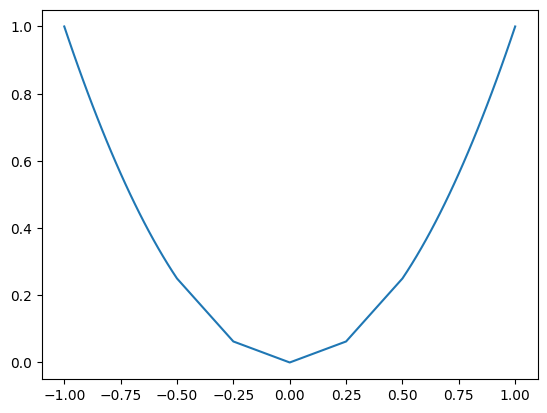

In [5]:
plt.plot(X, y)

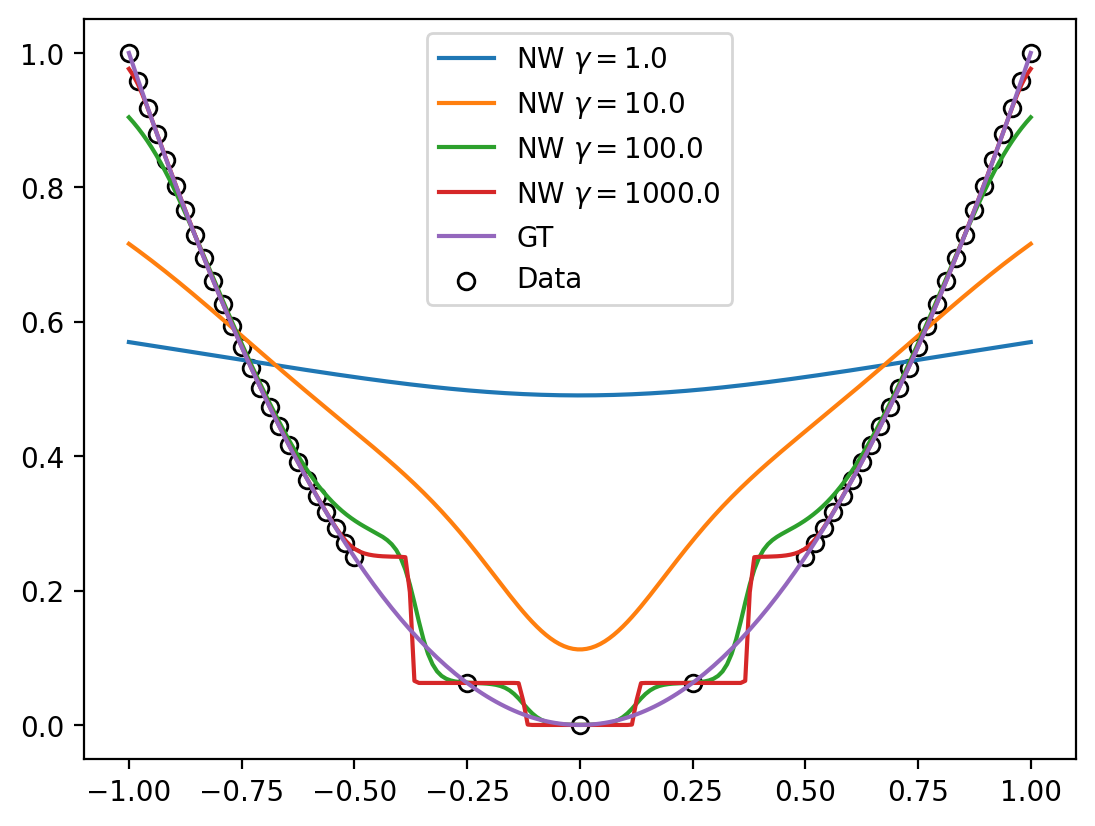

In [6]:
opacity = 1.0
plt.figure(dpi=200)
for gamma in [1., 10., 100., 1000.]:
    model = KernelRegression(gamma=gamma)
    model.fit(X, y)
    
    X_test = np.linspace(-1, 1, 200)[:, np.newaxis]
    plt.plot(X_test, model.predict(X_test), label=f'NW $\gamma={gamma}$', alpha=opacity)

plt.plot(X_test, target_fn(X_test), label='GT', alpha=opacity)
plt.scatter(X, y, label='Data', color='w', edgecolor='k', zorder=-1, alpha=opacity)

# plt.plot(
#     X_test,
#     KernelRidge(kernel='rbf', alpha=0.0, gamma=10.0).fit(X, y).predict(X_test),
#     label='KernelRidge'
# )
plt.legend()

c:\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


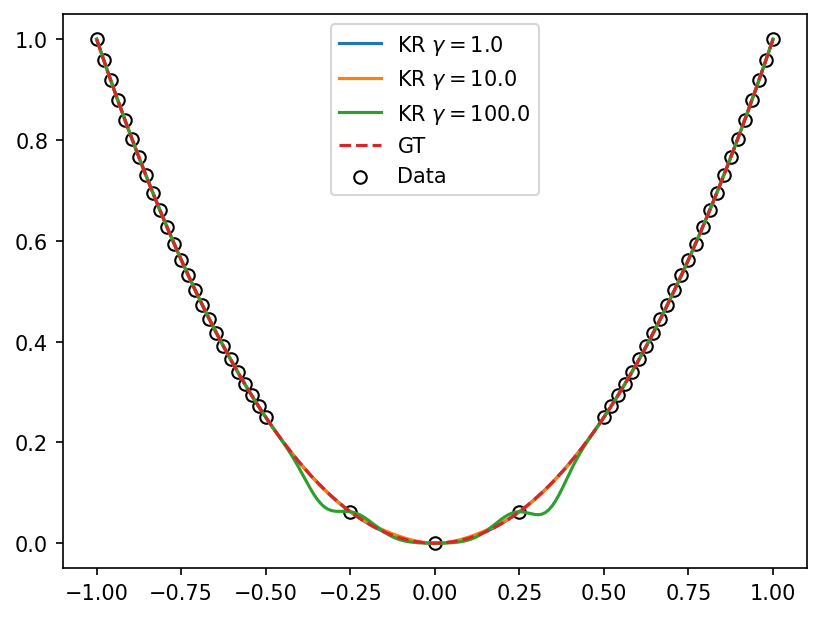

In [9]:
opacity = 1.0
plt.figure(dpi=150)
for gamma in [1., 10., 100.]:
    model = KernelRidge(kernel='rbf', alpha=0.0, gamma=gamma)
    model.fit(X, y)
    
    X_test = np.linspace(-1, 1, 200)[:, np.newaxis]
    plt.plot(X_test, model.predict(X_test), label=f'KR $\gamma={gamma}$', alpha=opacity)

plt.plot(X_test, target_fn(X_test), '--', label='GT', alpha=opacity)
plt.scatter(X, y, label='Data', color='w', edgecolor='k', zorder=-1, alpha=opacity)

plt.legend()